# Group Splitter (Standardized)

Refactored splitter that mirrors the `classify_groups` workflow:
- Reuses `graph_data` utilities for consistent node features and edge construction.
- Targets per-hit labels (pion, muon, pion+muon) with a cross-entropy objective.
- Prints per-class metrics and confusion matrices after every epoch.


In [2]:
import sys, os

PROJECT_ROOT = "/mnt/c/Users/obbee/research/notebooks/ML"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    os.environ["PYTHONPATH"] = PROJECT_ROOT + os.pathsep + os.environ.get("PYTHONPATH", "")


In [3]:
import math
import glob
import re
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch_geometric.loader import DataLoader

from graph_data.utils import fully_connected_edge_index, build_edge_attr
from graph_data.models import GroupSplitter

from torch_geometric.data import Data


In [4]:
_CHUNK_INDEX_RE = re.compile(r"_(\d+)\.npy$")

PION_MASK = 0b00001
MUON_MASK = 0b00010
POSITRON_MASK = 0b00100
ELECTRON_MASK = 0b01000
OTHER_MASK = 0b10000

NODE_LABEL_TO_NAME = {0: 'pion', 1: 'muon', 2: 'pion+muon'}
NUM_NODE_CLASSES = len(NODE_LABEL_TO_NAME)


def _extract_file_index(path: Path) -> Optional[int]:
    match = _CHUNK_INDEX_RE.search(path.name)
    return int(match.group(1)) if match else None


def _label_from_mask(mask: int) -> Optional[int]:
    has_pion = bool(mask & PION_MASK)
    has_muon = bool(mask & MUON_MASK)
    if has_pion and has_muon:
        return 2
    if has_pion:
        return 0
    if has_muon:
        return 1
    return None  # ignore hits that do not belong to pion/muon clusters


def load_splitter_groups(
    file_pattern: str,
    *,
    max_files: Optional[int] = None,
    limit_groups: Optional[int] = None,
    min_hits: int = 3,
    verbose: bool = True,
) -> List[Dict[str, Any]]:
    paths = [Path(p) for p in glob.glob(file_pattern)]
    if not paths:
        raise FileNotFoundError(f"No files matched pattern '{file_pattern}'")
    paths.sort(key=lambda p: (_extract_file_index(p) if _extract_file_index(p) is not None else math.inf, p.name))
    if max_files is not None:
        paths = paths[:max_files]

    records: List[Dict[str, Any]] = []
    label_totals = np.zeros(NUM_NODE_CLASSES, dtype=int)

    for path in paths:
        if limit_groups is not None and len(records) >= limit_groups:
            break
        chunk = np.load(path, allow_pickle=True)
        chunk_index = _extract_file_index(path) or 0

        for event_offset, event_groups in enumerate(chunk):
            if limit_groups is not None and len(records) >= limit_groups:
                break
            if event_groups is None or len(event_groups) == 0:
                continue

            for group_idx, raw_group in enumerate(event_groups):
                if limit_groups is not None and len(records) >= limit_groups:
                    break
                group = np.asarray(raw_group)
                if group.ndim != 2 or group.shape[0] < min_hits or group.shape[1] < 6:
                    continue

                mask_values = group[:, 5].astype(int)
                node_labels = []
                keep_indices = []
                for hit_idx, mask in enumerate(mask_values):
                    label = _label_from_mask(mask)
                    if label is None:
                        continue
                    keep_indices.append(hit_idx)
                    node_labels.append(label)

                if len(node_labels) < 2:
                    continue  # need at least two labelled hits to form a graph

                filtered = group[keep_indices]
                coord = filtered[:, 0].astype(np.float32)
                z_pos = filtered[:, 1].astype(np.float32)
                view_flag = filtered[:, 2].astype(np.float32)
                energy = filtered[:, 3].astype(np.float32)

                record_event_id: Optional[int] = None
                if filtered.shape[1] > 6:
                    try:
                        record_event_id = int(filtered[0, 6])
                    except (ValueError, TypeError):
                        record_event_id = None
                if record_event_id is None:
                    record_event_id = chunk_index * 100000 + event_offset

                records.append({
                    'coord': coord,
                    'z': z_pos,
                    'view': view_flag,
                    'energy': energy,
                    'node_labels': node_labels,
                    'event_id': record_event_id,
                    'group_id': len(records),
                })

                for lbl in node_labels:
                    label_totals[lbl] += 1

    if not records:
        raise ValueError('No labelled splitter groups found; adjust filtering thresholds.')

    if verbose:
        breakdown = ', '.join(f"{NODE_LABEL_TO_NAME[i]}: {int(label_totals[i])}" for i in range(NUM_NODE_CLASSES))
        print(f"Loaded {len(records)} splitter groups from {len(paths)} files ({breakdown})")

    return records


In [5]:
def _build_dataset(records: List[Dict[str, Any]]):
    data_list = []
    for record in records:
        coord = record['coord']
        z_pos = record['z']
        energy = record['energy']
        view = record['view']
        labels = record['node_labels']

        num_hits = coord.shape[0]
        group_energy = np.full(num_hits, energy.sum(), dtype=np.float32)
        node_features = torch.tensor(
            np.stack([coord, z_pos, energy, view, group_energy], axis=1), dtype=torch.float
        )

        edge_index = fully_connected_edge_index(num_hits, device=None)
        edge_attr = build_edge_attr(node_features, edge_index)

        data = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=torch.tensor(labels, dtype=torch.long),
        )
        if record.get('event_id') is not None:
            data.event_id = torch.tensor(int(record['event_id']), dtype=torch.long)
        if record.get('group_id') is not None:
            data.group_id = torch.tensor(int(record['group_id']), dtype=torch.long)
        data_list.append(data)

    return data_list


def _split_records(records: List[Dict[str, Any]], train_fraction: float, seed: int):
    if len(records) <= 1:
        return list(records), []
    rng = np.random.default_rng(seed)
    indices = rng.permutation(len(records))
    train_size = max(1, int(len(records) * train_fraction))
    if train_size >= len(records):
        train_size = len(records) - 1
    train_idx = indices[:train_size]
    val_idx = indices[train_size:]
    return [records[i] for i in train_idx], [records[i] for i in val_idx]


def _node_label_frequency(records: List[Dict[str, Any]]) -> np.ndarray:
    counts = np.zeros(NUM_NODE_CLASSES, dtype=int)
    for record in records:
        for lbl in record['node_labels']:
            counts[lbl] += 1
    return counts


def _make_loaders(
    records: List[Dict[str, Any]],
    *,
    train_fraction: float,
    batch_size: int,
    seed: int,
):
    train_records, val_records = _split_records(records, train_fraction, seed)
    train_dataset = _build_dataset(train_records)
    val_dataset = _build_dataset(val_records) if val_records else None
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None
    return train_loader, val_loader, train_records, val_records


In [12]:
def _init_confusion() -> np.ndarray:
    return np.zeros((NUM_NODE_CLASSES, NUM_NODE_CLASSES), dtype=np.int64)


def _update_confusion(confusion: np.ndarray, preds: torch.Tensor, targets: torch.Tensor) -> None:
    p = preds.detach().cpu().numpy()
    t = targets.detach().cpu().numpy()
    for truth, pred in zip(t, p):
        confusion[truth, pred] += 1


def _normalized(confusion: np.ndarray) -> np.ndarray:
    row_sums = confusion.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        normalized = np.divide(confusion, row_sums, out=np.zeros_like(confusion, dtype=float), where=row_sums != 0)
    return normalized


def _plot_confusion(title: str, confusion: np.ndarray, epoch: int) -> np.ndarray:
    normalized = _normalized(confusion)
    class_names = [NODE_LABEL_TO_NAME[i] for i in range(NUM_NODE_CLASSES)]

    fig, ax = plt.subplots(figsize=(5, 3.5))
    im = ax.imshow(normalized, cmap='Blues', vmin=0.0, vmax=1.0)
    ax.set_title(f"{title} confusion — epoch {epoch}")
    ax.set_xticks(range(NUM_NODE_CLASSES))
    ax.set_yticks(range(NUM_NODE_CLASSES))
    ax.set_xticklabels(class_names, rotation=30, ha='right')
    ax.set_yticklabels(class_names)

    for i in range(NUM_NODE_CLASSES):
        for j in range(NUM_NODE_CLASSES):
            value = normalized[i, j]
            count = confusion[i, j]
            text_color = 'white' if value > 0.6 else 'black'
            ax.text(j, i, f"{value:.5f}\n({count:d})", ha='center', va='center', color=text_color, fontsize=8)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    return normalized


def _run_train_epoch(model, loader, criterion, optimizer, device, grad_clip, threshold=0.5):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    confusion = _init_confusion()

    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        targets = batch.y
        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        if grad_clip is not None:
            clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        preds = logits.argmax(dim=1)
        correct = (preds == targets).sum().item()
        total_correct += correct
        total_examples += targets.size(0)
        total_loss += loss.item() * targets.size(0)
        _update_confusion(confusion, preds, targets)

    avg_loss = total_loss / max(total_examples, 1)
    avg_acc = total_correct / max(total_examples, 1)
    return avg_loss, avg_acc, confusion


def _run_eval_epoch(model, loader, criterion, device, threshold=0.5):
    if loader is None:
        return float('nan'), float('nan'), None

    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    confusion = _init_confusion()

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits = model(batch)
            targets = batch.y
            loss = criterion(logits, targets)

            preds = logits.argmax(dim=1)
            correct = (preds == targets).sum().item()
            total_correct += correct
            total_examples += targets.size(0)
            total_loss += loss.item() * targets.size(0)
            _update_confusion(confusion, preds, targets)

    if total_examples == 0:
        return float('nan'), float('nan'), None

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc, confusion


def train_group_splitter(
    records: List[Dict[str, Any]],
    *,
    model: Optional[GroupSplitter] = None,
    batch_size: int = 8,
    epochs: int = 30,
    lr: float = 1e-3,
    weight_decay: float = 1e-4,
    train_fraction: float = 0.85,
    seed: int = 42,
    device: Optional[str] = None,
    grad_clip: Optional[float] = None,
    scheduler_step_size: Optional[int] = 10,
    scheduler_gamma: float = 0.5,
):
    if not records:
        raise ValueError('No records provided for training.')

    device_obj = torch.device(device or ('cuda' if torch.cuda.is_available() else 'cpu'))
    model = model or GroupSplitter()
    model.to(device_obj)

    train_loader, val_loader, train_records, val_records = _make_loaders(
        records,
        train_fraction=train_fraction,
        batch_size=batch_size,
        seed=seed,
    )

    train_counts = _node_label_frequency(train_records)
    val_counts = _node_label_frequency(val_records) if val_records else None
    total_train_hits = max(train_counts.sum(), 1)
    class_weights = total_train_hits / np.maximum(train_counts, 1)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32, device=device_obj))
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = None
    if scheduler_step_size and scheduler_step_size > 0:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    history = []
    for epoch in range(1, epochs + 1):
        current_lr = optimizer.param_groups[0]['lr']
        train_loss, train_acc, train_conf = _run_train_epoch(model, train_loader, criterion, optimizer, device_obj, grad_clip)
        val_loss, val_acc, val_conf = _run_eval_epoch(model, val_loader, criterion, device_obj)

        if scheduler is not None:
            scheduler.step()

        if not np.isnan(val_loss):
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | train_loss={train_loss:.5f} acc={train_acc:.5f} "
                f"| val_loss={val_loss:.5f} acc={val_acc:.5f}"
            )
        else:
            print(
                f"Epoch {epoch:02d} | lr={current_lr:.5f} | train_loss={train_loss:.5f} acc={train_acc:.5f}"
            )

        train_norm = _plot_confusion('Train', train_conf, epoch)
        val_norm = None
        if val_conf is not None:
            val_norm = _plot_confusion('Val', val_conf, epoch)

        history.append({
            'epoch': epoch,
            'lr': current_lr,
            'train_loss': float(train_loss),
            'train_accuracy': float(train_acc),
            'train_confusion': train_conf.tolist(),
            'train_normalized': train_norm.tolist(),
            'val_loss': None if np.isnan(val_loss) else float(val_loss),
            'val_accuracy': None if np.isnan(val_acc) else float(val_acc),
            'val_confusion': None if val_conf is None else val_conf.tolist(),
            'val_normalized': None if val_norm is None else val_norm.tolist(),
        })

    return {
        'model': model,
        'history': history,
        'train_counts': train_counts.astype(int).tolist(),
        'val_counts': None if val_counts is None else val_counts.astype(int).tolist(),
        'class_weights': class_weights.tolist(),
    }


Loaded 20000 splitter groups from 4 files (pion: 292457, muon: 62234, pion+muon: 1218)
Epoch 01 | lr=0.00050 | train_loss=0.25561 acc=0.91151 | val_loss=0.18886 acc=0.87105


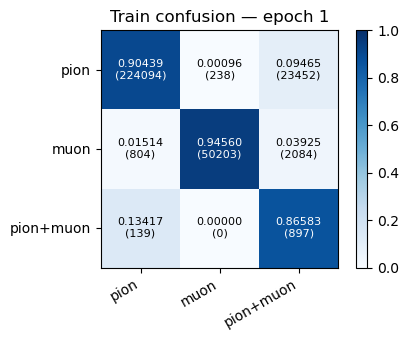

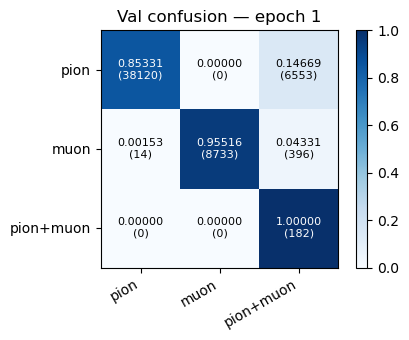

Epoch 02 | lr=0.00050 | train_loss=0.14385 acc=0.94273 | val_loss=0.12566 acc=0.96555


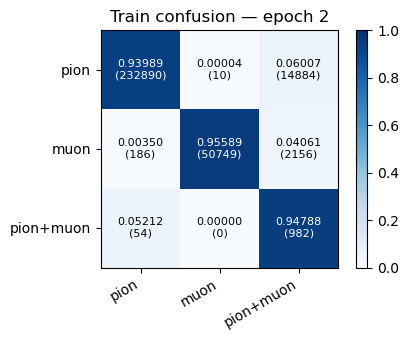

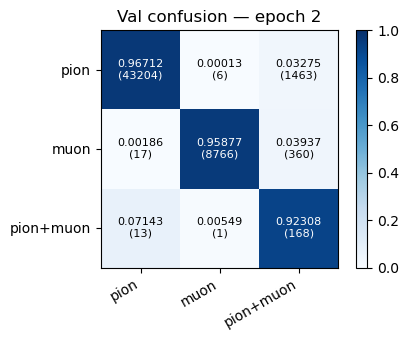

Epoch 03 | lr=0.00050 | train_loss=0.13953 acc=0.94841 | val_loss=0.18479 acc=0.98172


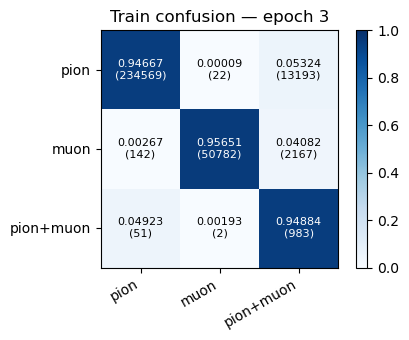

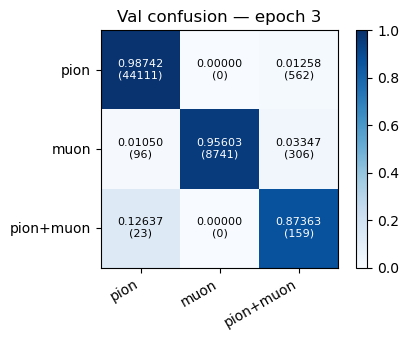

Epoch 04 | lr=0.00050 | train_loss=0.13856 acc=0.94969 | val_loss=0.11183 acc=0.95385


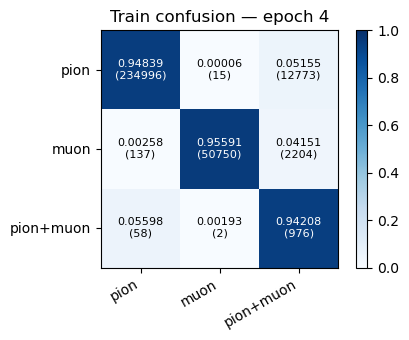

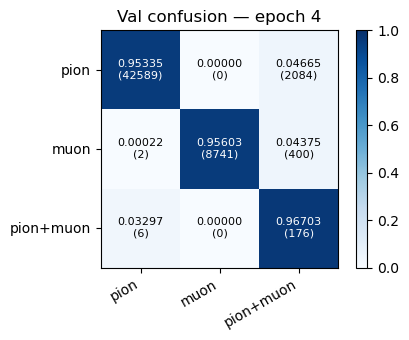

Epoch 05 | lr=0.00050 | train_loss=0.12432 acc=0.95001 | val_loss=0.15076 acc=0.97809


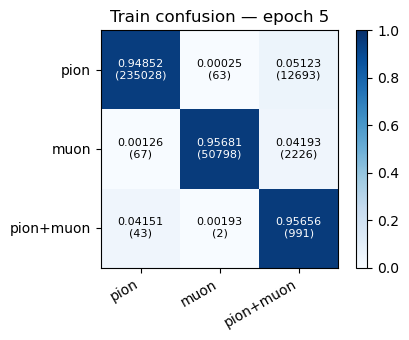

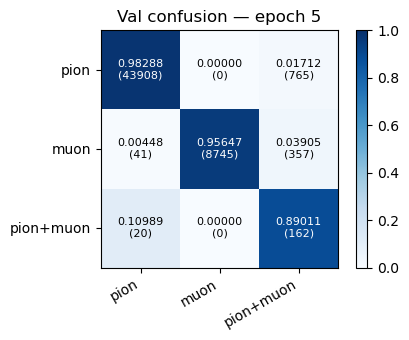

Epoch 06 | lr=0.00050 | train_loss=0.12300 acc=0.95322 | val_loss=0.18933 acc=0.85877


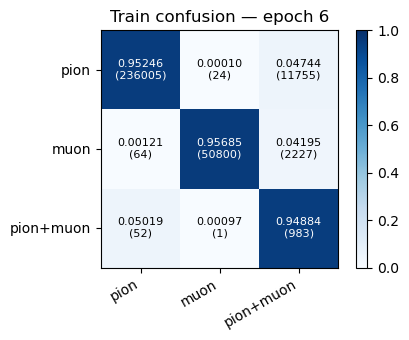

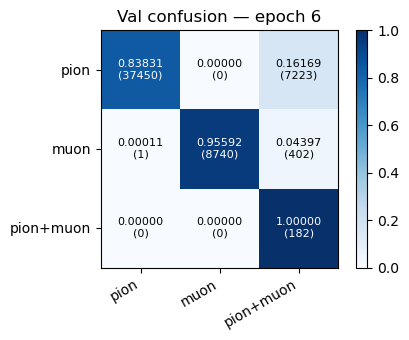

Epoch 07 | lr=0.00050 | train_loss=0.12492 acc=0.95265 | val_loss=0.12616 acc=0.93042


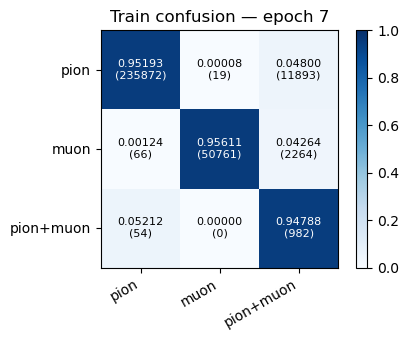

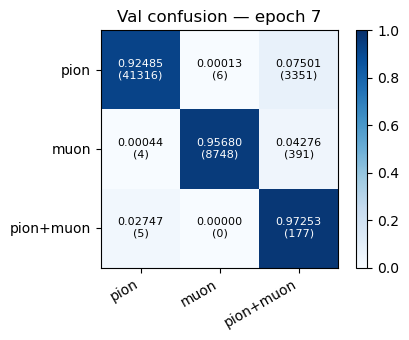

Epoch 08 | lr=0.00050 | train_loss=0.12162 acc=0.95231 | val_loss=0.11275 acc=0.95235


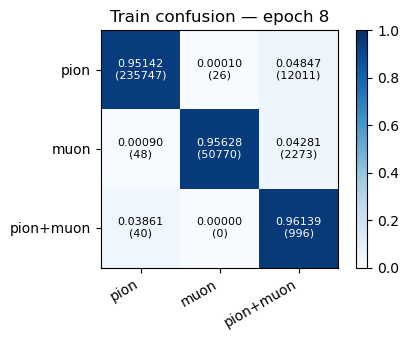

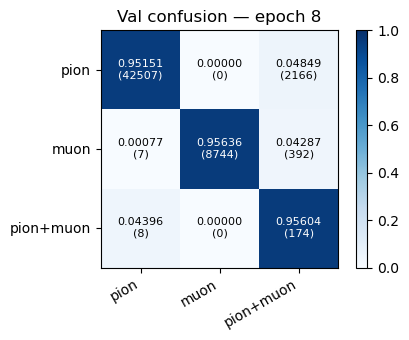

Epoch 09 | lr=0.00025 | train_loss=0.11117 acc=0.95457 | val_loss=0.11581 acc=0.96889


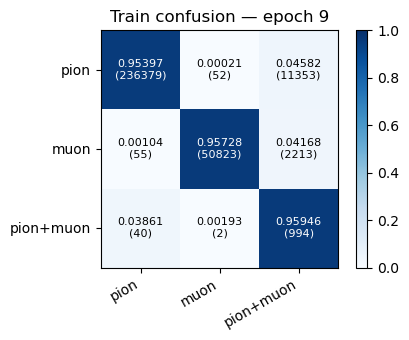

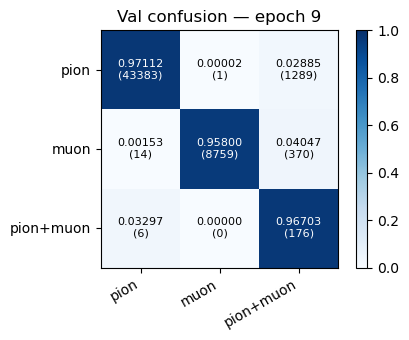

Epoch 10 | lr=0.00025 | train_loss=0.11353 acc=0.95701 | val_loss=0.10799 acc=0.94585


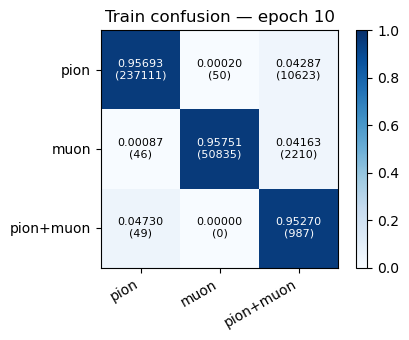

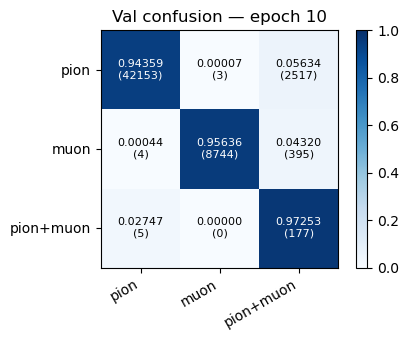

Epoch 11 | lr=0.00025 | train_loss=0.11208 acc=0.95493 | val_loss=0.10588 acc=0.94789


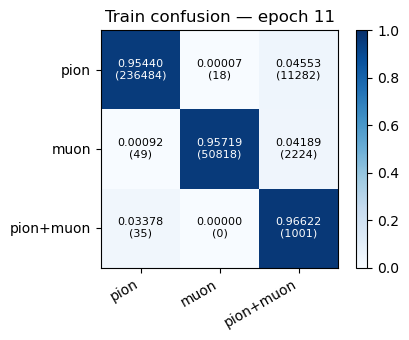

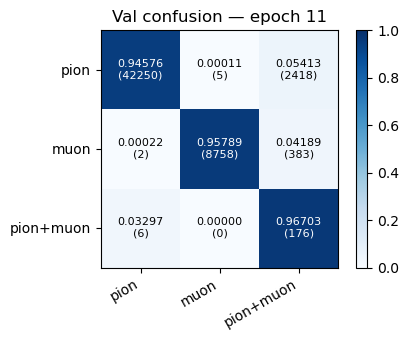

Epoch 12 | lr=0.00025 | train_loss=0.10951 acc=0.95548 | val_loss=0.13563 acc=0.91070


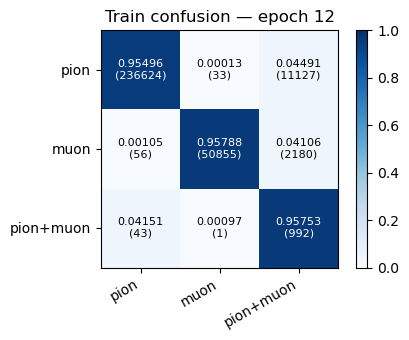

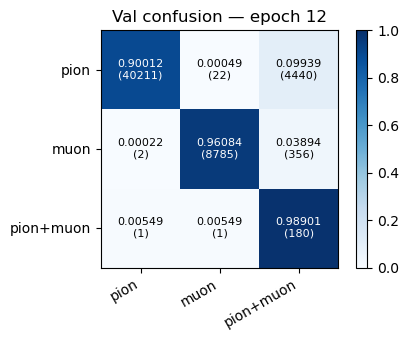

Epoch 13 | lr=0.00025 | train_loss=0.11240 acc=0.95724 | val_loss=0.10284 acc=0.96081


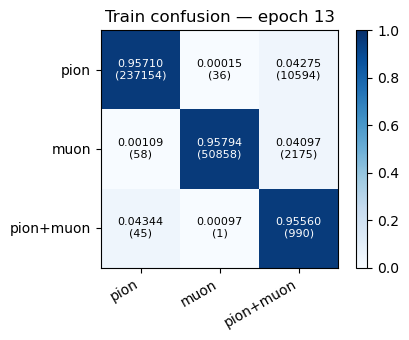

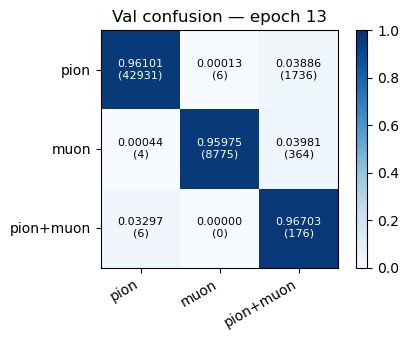

Epoch 14 | lr=0.00025 | train_loss=0.11045 acc=0.95543 | val_loss=0.11040 acc=0.96726


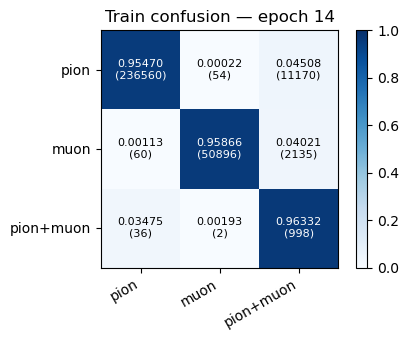

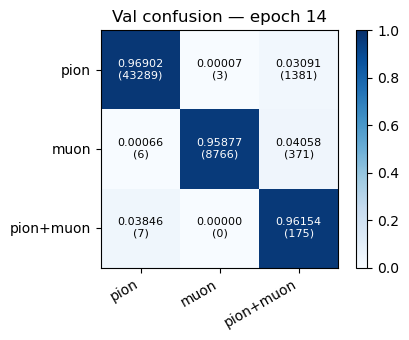

Epoch 15 | lr=0.00025 | train_loss=0.11059 acc=0.95608 | val_loss=0.10924 acc=0.96674


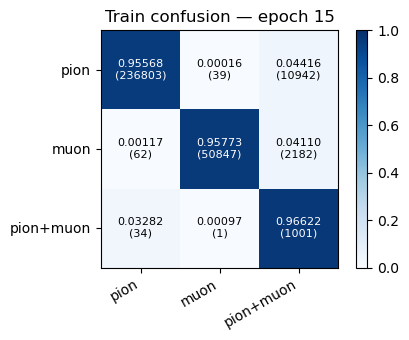

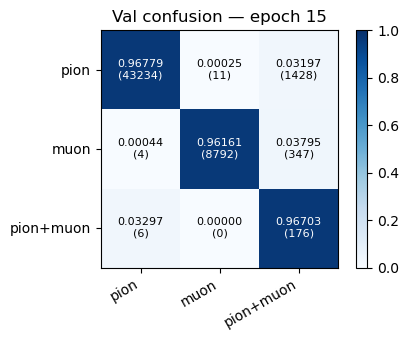

Epoch 16 | lr=0.00025 | train_loss=0.10758 acc=0.95692 | val_loss=0.11229 acc=0.95415


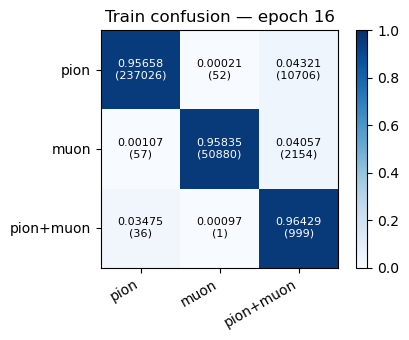

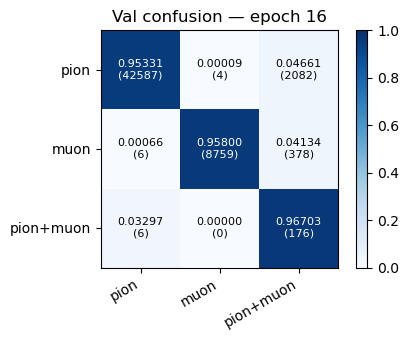

Epoch 17 | lr=0.00013 | train_loss=0.10291 acc=0.95756 | val_loss=0.10582 acc=0.96198


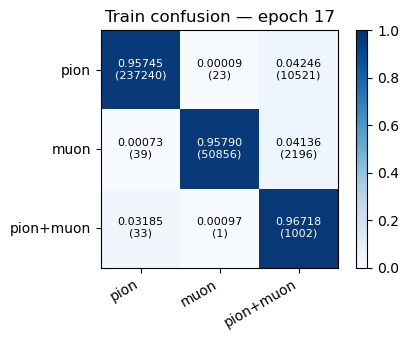

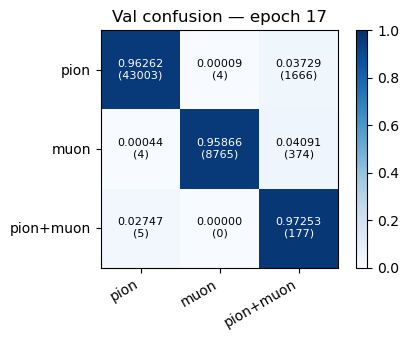

Epoch 18 | lr=0.00013 | train_loss=0.10221 acc=0.95930 | val_loss=0.10321 acc=0.96209


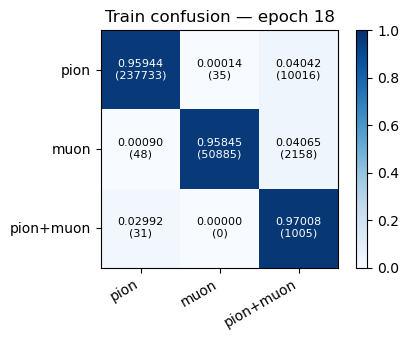

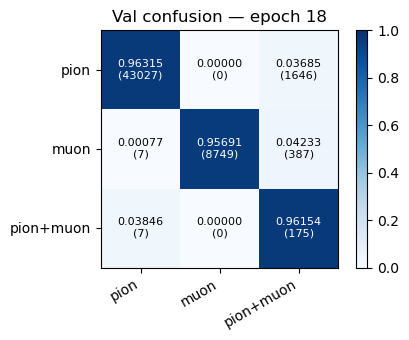

Epoch 19 | lr=0.00013 | train_loss=0.10456 acc=0.95877 | val_loss=0.10619 acc=0.94557


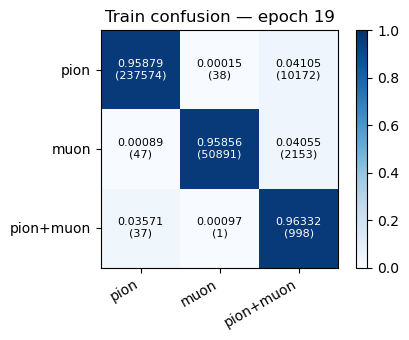

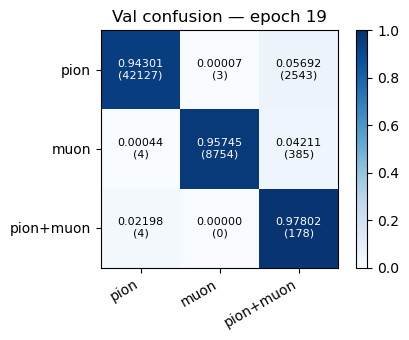

Epoch 20 | lr=0.00013 | train_loss=0.09939 acc=0.95975 | val_loss=0.10503 acc=0.96618


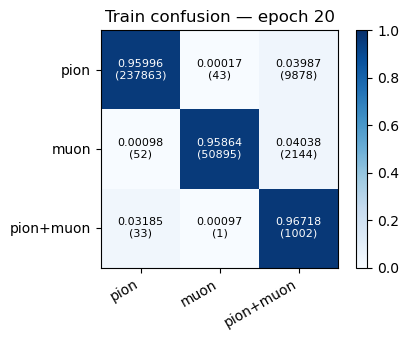

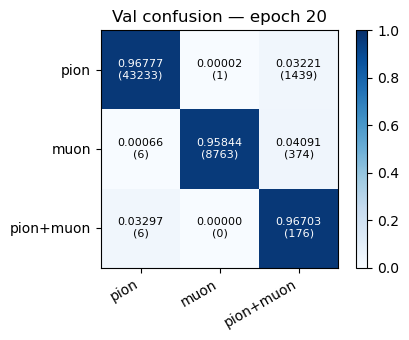

Epoch 21 | lr=0.00013 | train_loss=0.10274 acc=0.95815 | val_loss=0.10393 acc=0.94872


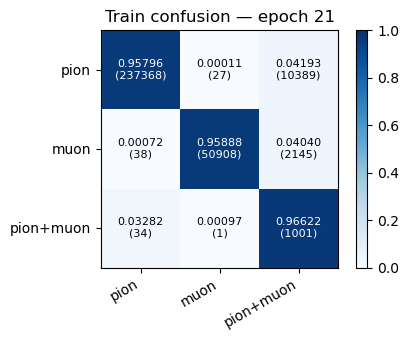

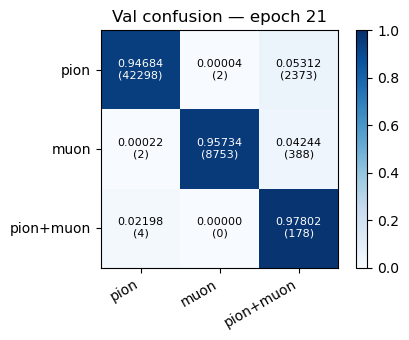

Epoch 22 | lr=0.00013 | train_loss=0.10127 acc=0.96011 | val_loss=0.10326 acc=0.96418


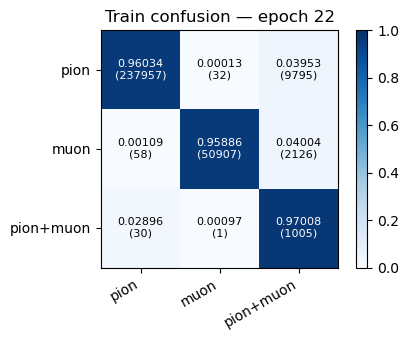

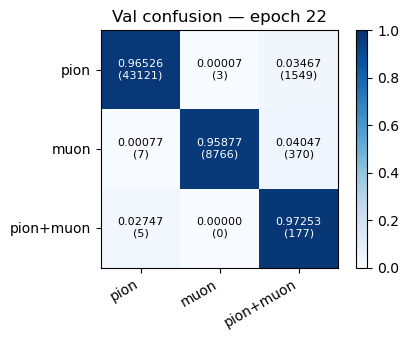

Epoch 23 | lr=0.00013 | train_loss=0.10156 acc=0.95798 | val_loss=0.10241 acc=0.95196


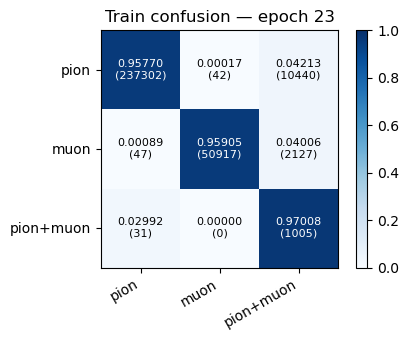

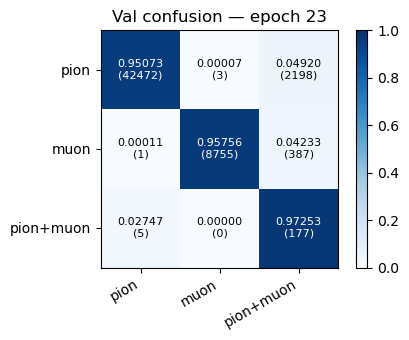

Epoch 24 | lr=0.00013 | train_loss=0.10281 acc=0.96043 | val_loss=0.10867 acc=0.94709


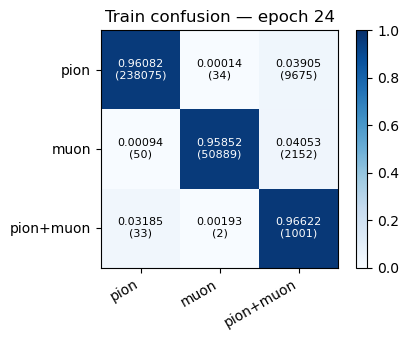

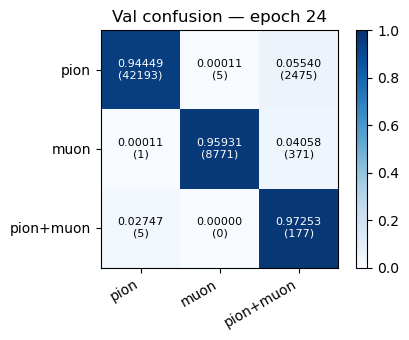

Epoch 25 | lr=0.00006 | train_loss=0.09883 acc=0.96059 | val_loss=0.10132 acc=0.96063


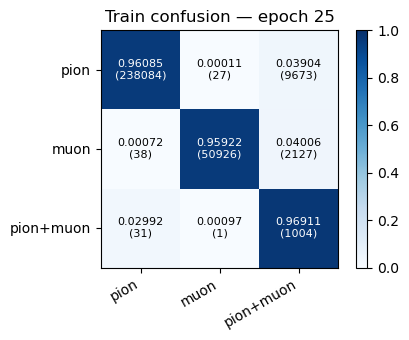

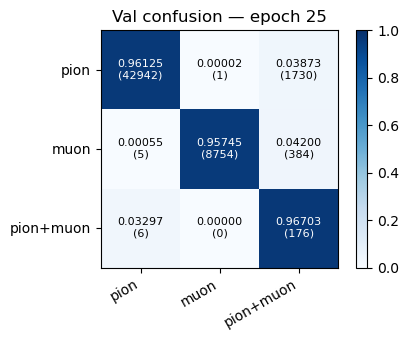

Node distribution (train): {'pion': 247784, 'muon': 53091, 'pion+muon': 1036}
Node distribution (val): {'pion': 44673, 'muon': 9143, 'pion+muon': 182}
Class weights: {'pion': 1.218, 'muon': 5.687, 'pion+muon': 291.42}


In [13]:
# Example pipeline (adjust file pattern and limits to suit your machine)
FILE_PATTERN = '/mnt/e/testML/pimuTimeGroups/mainTimeGroups_*.npy'

splitter_records = load_splitter_groups(
    FILE_PATTERN,
    max_files=4,
    limit_groups=20000,
    min_hits=1,
)

splitter_model = GroupSplitter(hidden=200, heads=4, layers=2, dropout=0.05)

results = train_group_splitter(
    splitter_records,
    model=splitter_model,
    batch_size=128,
    epochs=25,
    lr=5e-4,
    weight_decay=1e-5,
    train_fraction=0.85,
    seed=123,
    grad_clip=2.0,
    scheduler_step_size=8,
    scheduler_gamma=0.5,
)

print('Node distribution (train):', dict(zip(NODE_LABEL_TO_NAME.values(), results['train_counts'])))
if results['val_counts'] is not None:
    print('Node distribution (val):', dict(zip(NODE_LABEL_TO_NAME.values(), results['val_counts'])))
print('Class weights:', dict(zip(NODE_LABEL_TO_NAME.values(), [round(w, 3) for w in results['class_weights']])))
